### Configuration

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, Trainer
from torch.utils.data import Dataset, DataLoader
from multiprocessing import Pool
from functools import partial
from torch.nn import Softmax
import warnings
warnings.filterwarnings("ignore")

TEST_RATIO = 0.1 
MASTER_SEED = 42
MODEL_ID = 1
MODELS = (
    'klue/roberta-base', # 0
    'klue/roberta-large', # 1
    'klue/bert-base', # 2
    'monologg/koelectra-base-v3-discriminator' # 3    
)
MODEL_NAME = MODELS[MODEL_ID]
BATCH_SZIE = 50
REPETITIONS = 50
torch.cuda.is_available()

True

In [3]:
# Load Preprocess Youtube Data
youtube_df = pd.read_csv('../data/youtube_process/preprocess_youtube_df.csv', encoding='utf-8-sig',lineterminator='\n')
youtube_df = youtube_df[['publishedAt','videoTitle','clean_text']]
youtube_df.head()

,publishedAt,videoTitle,clean_text
0,2020-08-01T07:32:13Z,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,기상청 날씨하나 맞추는게 어렵니
1,2020-07-31T10:41:35Z,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,뭔 뉴스에 광고가 이리도 많나요 징허네 진짜
2,2020-07-31T09:59:54Z,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,잠금만 풀면되지 왜 오래들고 있냐증거물 없애려고 그러는거 아냐
3,2020-07-31T09:47:32Z,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,한똥훈 니 말을 어떻게 믿냐 미꾸라지 같어
4,2020-07-31T09:07:38Z,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,이슬비 보슬비 가랑비에호들갑


- Loading Saving Model

In [9]:
# loading saving model and tokenizer
model_path = '../Sentiment_Analysis/save_output/finetune_roberta-large_20240417_122910/checkpoint-9930' # RoBERTa-large
model_path = '../Sentiment_Analysis/output/further_pretrain_robert-large_20240619_173057/checkpoint-9930' # futther RoBERTa-large

model = AutoModelForSequenceClassification.from_pretrained(model_path,device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_path)
collator = DataCollatorWithPadding(tokenizer)

### Inference Youtube Data Sentiment
- inference time : 14h

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inference_texts = youtube_df['clean_text'].tolist()

batch_size = 100 # 한번에 처리할 데이터 수
batch_li = []
temp_li = []
prediction_results = []

for idx, text in enumerate(inference_texts):
    temp_li.append(text)
    if len(temp_li) == batch_size or idx == len(inference_texts) - 1:
        batch_li.append(temp_li)
        temp_li = []

for text_batch in tqdm(batch_li):
    # Tokenize and prepare inputa
    inference_encodings = tokenizer(text_batch, truncation=True, padding=True, return_tensors="pt")
    input_data = {key: tensor.to(device) for key, tensor in inference_encodings.items()}
    # Perform inference
    with torch.no_grad():
        model.eval()
        outputs = model(**input_data)
    # Calculate probabilities
    probabilities = torch.softmax(outputs.logits, dim=1).tolist()
    # Extract predicted labels
    predictions = outputs.logits.argmax(dim=1).tolist()
    sentiment_map = {0: 'happy', 1: 'angry', 2: 'sad', 3: 'neutral'}
    prediction_label = [sentiment_map[prediction] for prediction in predictions]
    # Combine labels with probabilities
    for i in range(len(text_batch)):
        result = {
            'Text': text_batch[i],
            'Top_Sentiment': prediction_label[i],
            'Prob_Happy': probabilities[i][0],
            'Prob_Angry': probabilities[i][1],
            'Prob_Sad': probabilities[i][2],
            'Prob_Neutral': probabilities[i][3]
        }
        prediction_results.append(result)

100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


In [15]:
inference_df = pd.DataFrame(prediction_results)
inference_df = pd.concat([youtube_df, inference_df], axis=1)
inference_df['Mental_index_score'] = (inference_df['Prob_Happy'] * +1) + (inference_df['Prob_Angry'] * -1) + (inference_df['Prob_Sad'] * -1) + (inference_df['Prob_Neutral'] * 0)
inference_df.head(3)

,publishedAt,videoTitle,text,Text,Top_Sentiment,Prob_Happy,Prob_Angry,Prob_Sad,Prob_Neutral,Mental_index_score
13,2020-07-31T05:12:54Z,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,"한동훈 너무 뻔뻔스럽다, 대한민국 법이 너무 웃켜, 법인이 큰소리 치고있고만.","한동훈 너무 뻔뻔스럽다, 대한민국 법이 너무 웃켜, 법인이 큰소리 치고있고만.",happy,0.623844,0.011767,0.356197,0.008191,0.255880
49,2020-07-30T23:55:16Z,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,애들아고맘다'''몰났리나서'내가살았다''코로나가나를인기올려주네'그래'그래잘한다'애들...,애들아고맘다'''몰났리나서'내가살았다''코로나가나를인기올려주네'그래'그래잘한다'애들...,happy,0.999581,0.000219,0.000033,0.000167,0.999328
78,2020-07-30T03:33:52Z,호우특보 - [LIVE] MBC 뉴스특보 2020년 7월 30일,"핵발전의 축복! 물부족 국가에서 물폭탄 국가로, 중국에 핵발전소 올 연말이면 49기...","핵발전의 축복! 물부족 국가에서 물폭탄 국가로, 중국에 핵발전소 올 연말이면 49기...",happy,0.999403,0.000472,0.000109,0.000016,0.998823


In [ ]:
inference_df[inference_df['Top_Sentiment'] == 'happy'][:3]

In [19]:
# inference_df.to_csv('../data/youtube_inference/inference_youtube_sentiment.csv',index=False,encoding='utf-8-sig')

- Mental Index Score

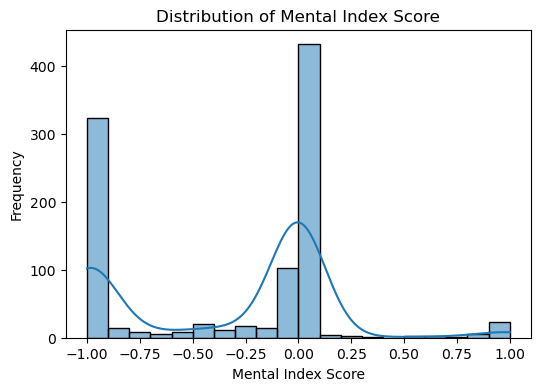

In [17]:
plt.figure(figsize=(6, 4))
sns.histplot(inference_df['Mental_index_score'], kde=True, bins=20)
plt.title('Distribution of Mental Index Score')
plt.xlabel('Mental Index Score')
plt.ylabel('Frequency')
plt.show()

### Checking Sentiment Distribution

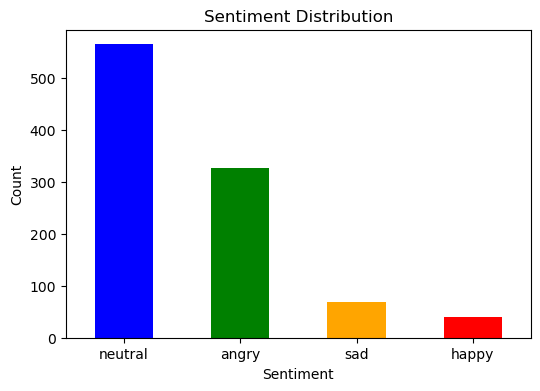

In [7]:
df = pd.read_csv('../data/youtube_inference/inference_youtube_sentiment.csv', lineterminator='\n')
df['sentiment_happy'] = df['Top_Sentiment'].apply(lambda x: 1 if x == 'happy' else 0)
df['sentiment_sad'] = df['Top_Sentiment'].apply(lambda x: 1 if x == 'sad' else 0)
df['sentiment_angry'] = df['Top_Sentiment'].apply(lambda x: 1 if x == 'angry' else 0)
df['sentiment_neutral'] = df['Top_Sentiment'].apply(lambda x: 1 if x == 'neutral' else 0)

colors = ['blue', 'green', 'orange', 'red']
sentiment_counts = df['Top_Sentiment'].value_counts()
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=colors)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=360)
plt.show()

- 일자별 감정 칼럼

In [25]:
df['publish_date'] = df['publishedAt'].str[:10]
daily_groupby = df.groupby('publish_date').sum()
daily_groupby = daily_groupby.reset_index()
daily_groupby['publish_date'] = pd.to_datetime(daily_groupby['publish_date'])
daily_groupby = daily_groupby.set_index('publish_date')
daily_groupby_2020 = daily_groupby['2020-01-01':'2020-12-31']
daily_groupby_2021 = daily_groupby['2021-01-01':'2021-12-31']
daily_groupby_2022 = daily_groupby['2022-01-01':'2022-12-31']

<Figure size 300x400 with 0 Axes>

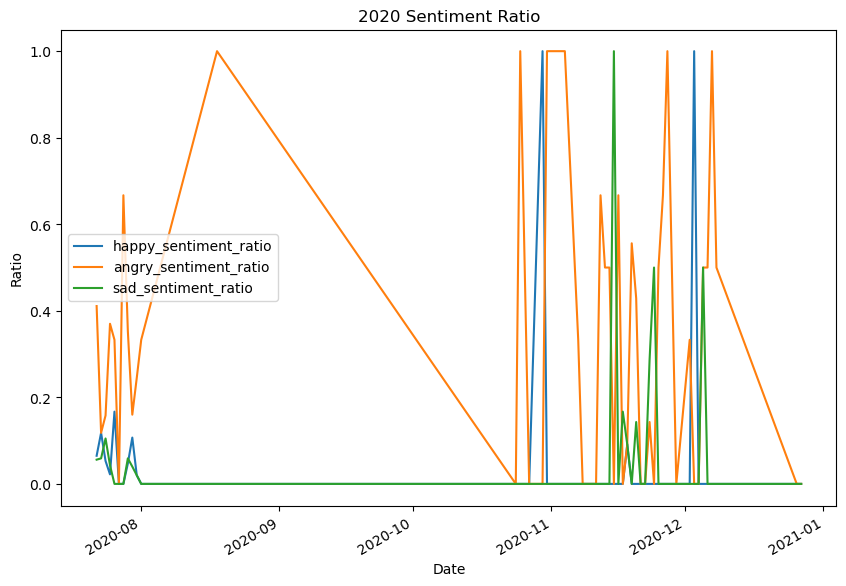

In [18]:
daily_groupby_2020['happy_sentiment_ratio'] = round((daily_groupby_2020['sentiment_happy']) / (daily_groupby_2020['sentiment_happy'] + daily_groupby_2020['sentiment_sad'] + daily_groupby_2020['sentiment_angry'] + daily_groupby_2020['sentiment_neutral']),3)
daily_groupby_2020['angry_sentiment_ratio'] = round((daily_groupby_2020['sentiment_angry']) / (daily_groupby_2020['sentiment_happy'] + daily_groupby_2020['sentiment_sad'] + daily_groupby_2020['sentiment_angry'] + daily_groupby_2020['sentiment_neutral']),3)
daily_groupby_2020['sad_sentiment_ratio'] = round((daily_groupby_2020['sentiment_sad']) / (daily_groupby_2020['sentiment_happy'] + daily_groupby_2020['sentiment_sad'] + daily_groupby_2020['sentiment_angry'] + daily_groupby_2020['sentiment_neutral']),3)
plt.figure(figsize=(3, 4))
daily_groupby_2020.plot(y=['happy_sentiment_ratio','angry_sentiment_ratio','sad_sentiment_ratio'],figsize=(10,7))
plt.title('2020 Sentiment Ratio')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

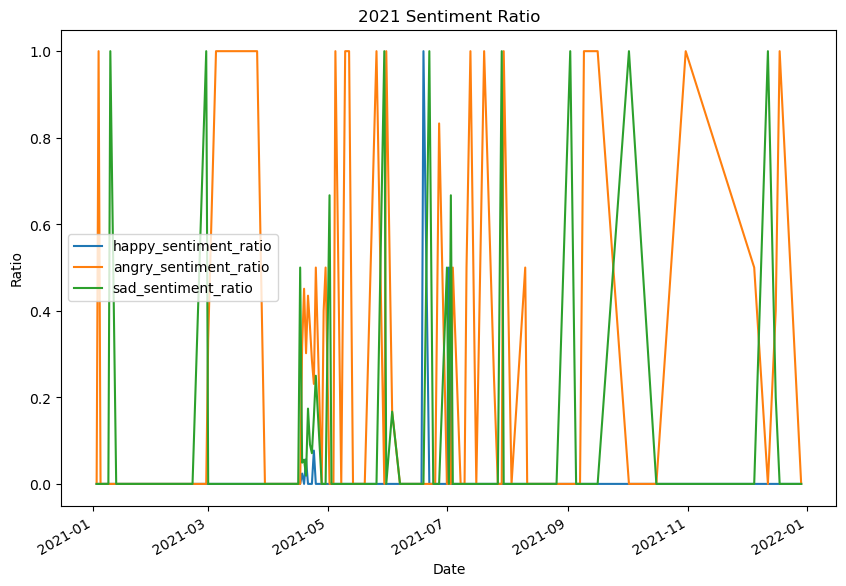

In [19]:
daily_groupby_2021['happy_sentiment_ratio'] = round((daily_groupby_2021['sentiment_happy']) / (daily_groupby_2021['sentiment_happy'] + daily_groupby_2021['sentiment_sad'] + daily_groupby_2021['sentiment_angry'] + daily_groupby_2021['sentiment_neutral']),3)
daily_groupby_2021['angry_sentiment_ratio'] = round((daily_groupby_2021['sentiment_angry']) / (daily_groupby_2021['sentiment_happy'] + daily_groupby_2021['sentiment_sad'] + daily_groupby_2021['sentiment_angry'] + daily_groupby_2021['sentiment_neutral']),3)
daily_groupby_2021['sad_sentiment_ratio'] = round((daily_groupby_2021['sentiment_sad']) / (daily_groupby_2021['sentiment_happy'] + daily_groupby_2021['sentiment_sad'] + daily_groupby_2021['sentiment_angry'] + daily_groupby_2021['sentiment_neutral']),3)
daily_groupby_2021.plot(y=['happy_sentiment_ratio','angry_sentiment_ratio','sad_sentiment_ratio'],figsize=(10,7))
plt.title('2021 Sentiment Ratio')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

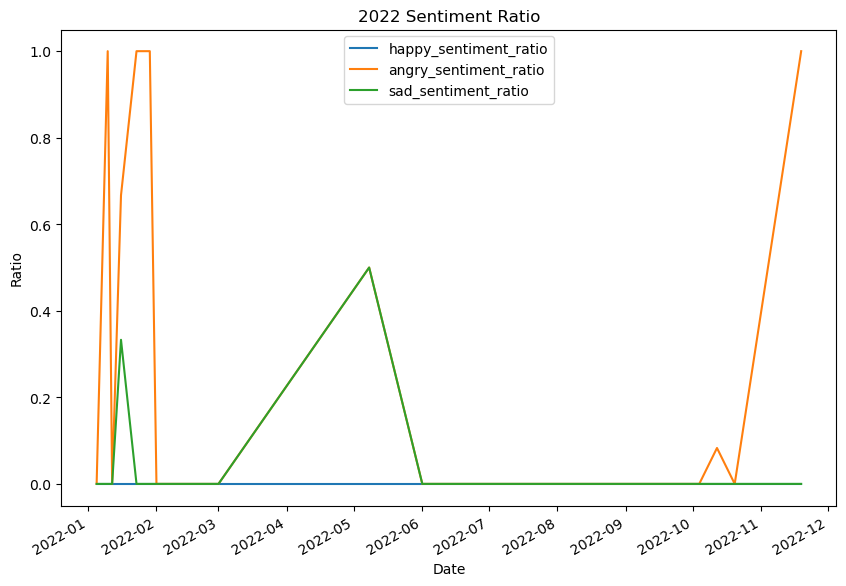

In [20]:
daily_groupby_2022['happy_sentiment_ratio'] = round((daily_groupby_2022['sentiment_happy']) / (daily_groupby_2022['sentiment_happy'] + daily_groupby_2022['sentiment_sad'] + daily_groupby_2022['sentiment_angry'] + daily_groupby_2022['sentiment_neutral']),3)
daily_groupby_2022['angry_sentiment_ratio'] = round((daily_groupby_2022['sentiment_angry']) / (daily_groupby_2022['sentiment_happy'] + daily_groupby_2022['sentiment_sad'] + daily_groupby_2022['sentiment_angry'] + daily_groupby_2022['sentiment_neutral']),3)
daily_groupby_2022['sad_sentiment_ratio'] = round((daily_groupby_2022['sentiment_sad']) / (daily_groupby_2022['sentiment_happy'] + daily_groupby_2022['sentiment_sad'] + daily_groupby_2022['sentiment_angry'] + daily_groupby_2022['sentiment_neutral']),3)
daily_groupby_2022.plot(y=['happy_sentiment_ratio','angry_sentiment_ratio','sad_sentiment_ratio'],figsize=(10,7))
plt.title('2022 Sentiment Ratio')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

- 월별 감정 칼럼

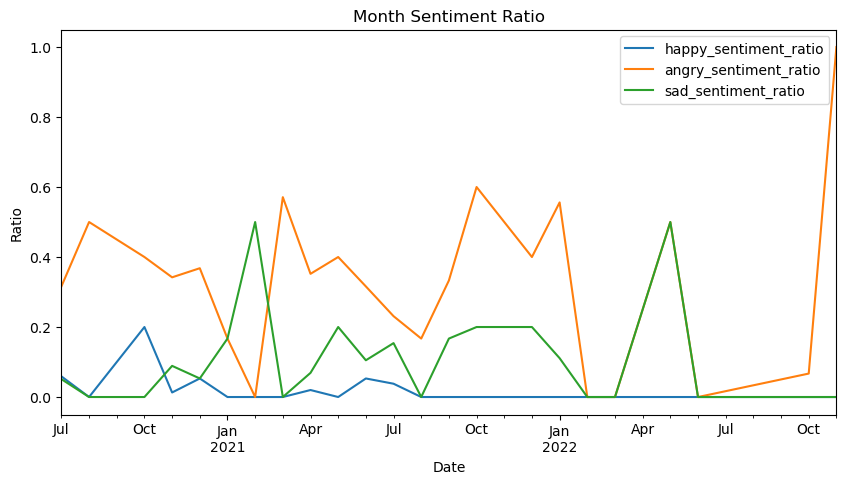

In [22]:
daily_groupby.reset_index(inplace=True)
month_groupby = daily_groupby.groupby(daily_groupby['publish_date'].dt.to_period('M')).sum()
month_groupby['happy_sentiment_ratio'] = round((month_groupby['sentiment_happy']) / (month_groupby['sentiment_happy'] + month_groupby['sentiment_sad'] + month_groupby['sentiment_angry'] + month_groupby['sentiment_neutral']),3)
month_groupby['angry_sentiment_ratio'] = round((month_groupby['sentiment_angry']) / (month_groupby['sentiment_happy'] + month_groupby['sentiment_sad'] + month_groupby['sentiment_angry'] + month_groupby['sentiment_neutral']),3)
month_groupby['sad_sentiment_ratio'] = round((month_groupby['sentiment_sad']) / (month_groupby['sentiment_happy'] + month_groupby['sentiment_sad'] + month_groupby['sentiment_angry'] + month_groupby['sentiment_neutral']),3)

month_groupby.plot(y=['happy_sentiment_ratio','angry_sentiment_ratio','sad_sentiment_ratio'],figsize=(10,5))
plt.title('Month Sentiment Ratio')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

In [ ]:
# month_groupby.reset_index(inplace=True)
daily_groupby.to_csv('../data/daily_youtube_sentiment_cnt.csv',index=False)
month_groupby.to_csv('../data/monthly_youtube_sentiment_cnt.csv',index=False)

### checking inference time

In [34]:
# Configuration
BATCH_SIZE = 50 # 한번에 처리할 데이터 수
DATA_SIZE = 500 # 데이터 크기
REPETITIONS = 2 # 추론 반복 횟수
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize CUDA events for timing
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
# Time of the task (each row represents the inference time for one operation, in milliseconds (=1000*seconds))
timings = np.zeros((REPETITIONS, 1)) 
total_batch_average_time = 0
batch_li = []
temp_li = []
prediction_results = []
inference_texts = youtube_df['text'].tolist()[:DATA_SIZE]
for idx, text in enumerate(inference_texts):
    temp_li.append(text)
    if len(temp_li) == BATCH_SIZE or idx == len(inference_texts) - 1:
        batch_li.append(temp_li)
        temp_li = []

# Measure performance
for text_batch in tqdm(batch_li):
    # Tokenize and prepare input
    inference_encodings = tokenizer(text_batch, truncation=True, padding=True, return_tensors="pt")
    input_data = {key: tensor.to(device) for key, tensor in inference_encodings.items()}
    # Perform inference
    with torch.no_grad():
        for rep in range(REPETITIONS):        
            # Record start time
            starter.record() 
            model.eval()
            outputs = model(**input_data)
            ender.record()
            # Record end time 
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time
    average_time = round(np.mean(timings / 100), 2) 
total_batch_average_time += average_time
print(f'{DATA_SIZE}개 댓글 {MODEL_NAME} inference time : ', total_batch_average_time, '초')

100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

500개 댓글 roberta-large inference time :  9.18 초


In [3]:
import pandas as pd
pd.read_csv('../data/youtube_df.csv')

,publishedAt,channelId,videoDate,videoId,videoTitle,text,like
0,2020-08-01T07:32:13Z,UCF4Wxdo3inmxP-Y59wXDsFw,2020-07-30,ncO8E0UHikE,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,기상청 날씨하나 맞추는게 어렵니?,0.0
1,2020-07-31T10:41:35Z,UCF4Wxdo3inmxP-Y59wXDsFw,2020-07-30,ncO8E0UHikE,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,"뭔 뉴스에 광고가 이리도 많나요? 징허네, 진짜",0.0
2,2020-07-31T09:59:54Z,UCF4Wxdo3inmxP-Y59wXDsFw,2020-07-30,ncO8E0UHikE,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,잠금만 풀면되지 왜 오래들고 있냐..증거물 없애려고 그러는거 아냐..,0.0
3,2020-07-31T09:47:32Z,UCF4Wxdo3inmxP-Y59wXDsFw,2020-07-30,ncO8E0UHikE,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,한똥훈 니 말을 어떻게 믿냐! 미꾸라지 같어.,0.0
4,2020-07-31T09:07:38Z,UCF4Wxdo3inmxP-Y59wXDsFw,2020-07-30,ncO8E0UHikE,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,이슬비 보슬비 가랑비에\n호들갑,0.0
...,...,...,...,...,...,...,...
3121496,2021-02-06T03:20:15Z,UCF4Wxdo3inmxP-Y59wXDsFw,2021-02-06,gv0G4__vgLc,"비수도권 밤 10시로 완화화이자·모더나 백신, 안전 - [LIVE] MBC 12시뉴...",9시에서10시로\n것도 수도권은 빼고\n참 지랄도 가지가지한다\n씨부리는 주둥아리를...,1.0
3121497,2021-02-06T03:17:59Z,UCF4Wxdo3inmxP-Y59wXDsFw,2021-02-06,gv0G4__vgLc,"비수도권 밤 10시로 완화화이자·모더나 백신, 안전 - [LIVE] MBC 12시뉴...",수도권도 밤 10시로 완화하라,2.0
3121498,2021-02-06T03:12:40Z,UCF4Wxdo3inmxP-Y59wXDsFw,2021-02-06,gv0G4__vgLc,"비수도권 밤 10시로 완화화이자·모더나 백신, 안전 - [LIVE] MBC 12시뉴...",mbc 정부 빨아주느라 고생한다...아스트라제네카 부작용이 문제가 아니라 효과가 없...,1.0
3121499,2021-02-04T08:21:40Z,UCF4Wxdo3inmxP-Y59wXDsFw,2021-02-04,7fPPvc0rcd8,"공급 쇼크…집값 잡히나, 법관 탄핵안 통과..의미는, 변이 바이러스…4차 대유행 전...",사법부길들이기 좋아하시네 국민의 지지를 업고 계란으로 바위치기를 하는겁니다 민주당화이팅,2.0
